#### 聚类的目的
对不同的用户进行针对性的召回方案：  
* 是否付费是一个重要的区别指标；这类用户如果召回的话，再次产生付费的可能性应该会比未付费的要大；对于这些用户，我们可以采取一些发放游戏币或者促销的活动来吸引其回来
* 未付费的用户，也需要根据其游戏币来源，判断是否有付费的潜力；
* 不同场次的用户，也代表了不同的用户玩牌类型；大场次往往输赢大，这类用户的玩牌水平和付费能力应该更强，如果采用一些小的折扣可能对他们没有太大的影响，他们可能会更倾向于比赛赢取实物之类的活动
* 用户在游戏中的行为也是变化的，不同的生命周期阶段可能有不同的心理。一些重要的转折，比如说从低场次玩到高场次，或者从高场次又降回低场次；好的游戏应该让用户花费时间或者金钱，才能不断地往上走或者稳定在高级别；
* 我们可以在用户不同的阶段，针对性地进行一些促销活动或者激励措施，比如第一次从低场次玩到高场次，可能因为技术不熟练，导致一下子又落回到低场次，可以给一些打折的礼包，促使用户付费，而且可以激励用户持续在高场次玩牌

#### 用户风格指标
* 总场次时长
* 付费金额
* 游戏币来源（确定用户的付费意愿）
* 游戏币去向（比如如果有一些回收游戏币的活动，这个用户是否喜欢参与；还有的用户会用游戏币去购买道具这些）
* 游戏币结余（可能会对召回的难易程度有影响：游戏币剩余多的用户可能更容易被召回？）
* 生命周期（不同生命周期的用户是否会有不同，比如老用户是否已经对游戏产生了厌倦？）
* 最后登录距离当前的天数（也是确定召回难易程度的重要指标）

#### 对于已流失用户（最后登录大于30天）
* 总付费金额
* 游戏币来源，赢牌占比
* 游戏币来源，系统发放占比
* 游戏币来源，付费占比
* 游戏币流通总额
* 最后剩余游戏币数量
* 不同场次时长占比
* 生命周期

#### 对于还未流失的用户
* 总付费金额
* 总游戏币来源，赢牌占比
* 最近14天，游戏币来源，赢牌占比
* 最近14天，游戏币来源，系统发放占比
* 最近14天，游戏币来源，付费占比
* 最近14天，场次时长占比
* 游戏币流通总额
* 生命周期
* 最近14天，登录次数

#### 建表
 用户玩牌行为画像表（针对全体用户）
* bpid
* mid
* pay_sum 总付费金额
* getcoin_win 游戏币来源，赢牌占比（小数点后4位）
* getcoin_sys 游戏币来源，系统发放占比（小数点后4位）
* getcoin_pay 游戏币来源，付费占比（小数点后4位）
* coin_in_out 游戏币流通总额
* coin_left 结余游戏币数量
* lifetime 生命周期
* high_party 高级场次时长占比
* middle_party 中级场次时长占比
* low_party 低级场次时长占比


建表语句
```sql

with paysum as
(select fbpid,mid,sum(fcoins_num) as pay_sum
from stage.payment_stream_stg
group by fbpid,mid
)

```

#### 由于其他游戏的货币来源这些还得另外建表，我们先用地方棋牌的数据来建模（确定好字段后再应用到其他游戏上）

建表语句
```sql

CREATE table tempwork.fiona_2018_0827_julei as
WITH a1 AS
  (SELECT fbpid,
          mid,
          lifespan,
          pay_sum,
          latest_login_time
   FROM veda.dfqp_user_portrait
   where substr(latest_login_time,1,10) > '2018-02-01'
   ORDER BY rand()
   limit 10000),
     a2 AS
  (SELECT fbpid,
          fuid,
          coin_source,
          coin_type,
          sum(if(coin_type_num > 0, coin_type_num, 0)) over(partition BY fbpid, fuid, coin_type, coin_source) AS coin_subtotal,
          sum(if(coin_type = '金条', coin_type_num * 100, coin_type_num)) over(partition BY fbpid, fuid) AS total_coin
   FROM stage_dfqp.user_coin_source_tag ),
     a3 AS
  (SELECT b1.fbpid AS fbpid,
          b1.fuid AS fuid,
          sum(CASE
                  WHEN unix_timestamp(b1.fe_timer) - unix_timestamp(b1.fs_timer) BETWEEN 1 AND 10800 THEN unix_timestamp(b1.fe_timer) - unix_timestamp(b1.fs_timer)
                  ELSE 0
              END) over(partition BY b1.fbpid,b1.fuid) AS play_duration,
          sum(CASE
                  WHEN unix_timestamp(b1.fe_timer) - unix_timestamp(b1.fs_timer) BETWEEN 1 AND 10800 THEN unix_timestamp(b1.fe_timer) - unix_timestamp(b1.fs_timer)
                  ELSE 0
              END) over(partition BY b1.fbpid,b1.fuid,b2.room_subtype_desc) AS play_duration_subname,
          b2.room_subtype_desc AS subname
   FROM stage_dfqp.user_gameparty_stg b1
   JOIN dw_dfqp.dim_subgame b2 ON b1.fsubname = b2.subgame_room_id)
SELECT a1.fbpid AS fbpid,
       a1.mid AS fuid,
       a1.lifespan AS lifespan,
       a1.pay_sum AS pay_sum,
       a1.latest_login_time AS latest_login_time,
       a2.coin_source AS coin_source,
       round(if(a2.coin_type = '金条', a2.coin_subtotal * 100, a2.coin_subtotal)/a2.total_coin*100,4) AS coin_percent,
       a3.subname,
       round(a3.play_duration_subname/a3.play_duration,4) AS subname_percent
FROM a1
LEFT JOIN a2 ON a1.fbpid = a2.fbpid
AND a1.mid = a2.fuid
LEFT JOIN a3 ON a1.fbpid = a3.fbpid
AND a1.mid = a3.fuid

```

```sql
SELECT fbpid,
       fuid,
       lifespan,
       pay_sum,
       substr(latest_login_time,1,10) AS latest_login_time,
       max( CASE
                WHEN coin_source='NULL' THEN cast(coin_percent as decimal(20,4))
                ELSE 0
            END) AS `NULL`,
       max( CASE
                WHEN coin_source='付费' THEN cast(coin_percent as decimal(20,4))
                ELSE 0
            END) AS `付费`,
       max( CASE
                WHEN coin_source='赢牌获得' THEN cast(coin_percent as decimal(20,4))
                ELSE 0
            END) AS `赢牌获得`,
       max( CASE
                WHEN coin_source='系统产出' THEN cast(coin_percent as decimal(20,4))
                ELSE 0
            END) AS `系统产出`,
       max( CASE
                WHEN coin_source='兑换' THEN cast(coin_percent as decimal(20,4))
                ELSE 0
            END) AS `兑换`,
       max(CASE
               WHEN subname='NULL' THEN cast(subname_percent*100 as decimal(20,4))
               ELSE 0
           END) AS `NULL`,
       max(CASE
               WHEN subname='高级场' THEN cast(subname_percent*100 as decimal(20,4))
               ELSE 0
           END) AS `高级场`,
       max(CASE
               WHEN subname='职业场' THEN cast(subname_percent*100 as decimal(20,4))
               ELSE 0
           END) AS `职业场`,
       max(CASE
               WHEN subname='私人场' THEN cast(subname_percent*100 as decimal(20,4))
               ELSE 0
           END) AS `私人场`,
       max(CASE
               WHEN subname='中级场' THEN cast(subname_percent*100 as decimal(20,4))
               ELSE 0
           END) AS `中级场`,
       max(CASE
               WHEN subname='新手场' THEN cast(subname_percent*100 as decimal(20,4))
               ELSE 0
           END) AS `新手场`
FROM tempwork.fiona_2018_0827_julei
GROUP BY fbpid,
         fuid,
         lifespan,
         pay_sum,
         substr(latest_login_time,1,10)

```

In [2]:
import pandas as pd
import numpy as np
from pandas import Series,DataFrame
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
# 允许多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
data = pd.read_csv('./data-julei.csv')
data.head(10)
data_julei = data[['lifespan','pay_sum','付费','赢牌获得','系统产出','兑换','高级场','职业场','私人场','中级场','新手场']]

,fbpid,fuid,lifespan,pay_sum,latest_login_time,null,付费,赢牌获得,系统产出,兑换,null.1,高级场,职业场,私人场,中级场,新手场
0,384C601DAA0369E7BB9AECC1D53D3437,1002348033,264,0.00,2018-07-30,0.0,0.0000,0.0000,100.0000,0.0,0.0,0.00,0.0,0.00,0.00,100.00
1,384C601DAA0369E7BB9AECC1D53D3437,1002353776,101,0.00,2018-02-18,0.0,0.0000,0.0000,100.0000,0.0,0.0,0.00,0.0,0.00,17.73,82.27
2,384C601DAA0369E7BB9AECC1D53D3437,1002449614,67,0.00,2018-02-20,0.0,0.0000,49.6746,50.3254,0.0,0.0,0.00,0.0,25.59,0.00,74.41
3,384C601DAA0369E7BB9AECC1D53D3437,1002774494,24,6.95,2018-04-11,0.0,85.2618,0.0000,14.7382,0.0,0.0,0.94,0.0,0.00,17.89,81.17
4,384C601DAA0369E7BB9AECC1D53D3437,1002995874,77,0.00,2018-08-25,0.0,0.0000,59.5219,40.4781,0.0,0.0,0.00,0.0,0.00,1.85,98.15
5,384C601DAA0369E7BB9AECC1D53D3437,1003025503,1,0.00,2018-06-30,0.0,0.0000,0.0000,100.0000,0.0,0.0,0.00,0.0,0.00,0.00,100.00
6,384C601DAA0369E7BB9AECC1D53D3437,1003035621,33,0.00,2018-08-08,0.0,0.0000,0.0000,100.0000,0.0,0.0,0.00,0.0,0.00,0.00,100.00
7,384C601DAA0369E7BB9AECC1D53D3437,1003046855,1,0.00,2018-07-14,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.00,0.0,0.00,0.00,0.00
8,BD5FDCFA71A9CD5313766DAE14B56F9F,1002268081,309,0.00,2018-08-25,0.0,0.0000,40.1957,59.8043,0.0,0.0,0.65,0.0,0.00,4.91,94.44
9,BD5FDCFA71A9CD5313766DAE14B56F9F,1002455699,251,0.00,2018-08-26,0.0,0.0000,0.9353,99.0647,0.0,0.0,9.40,0.0,0.00,9.46,81.14


In [179]:
len(data)

10000

In [6]:
pd.DataFrame(data.isnull().sum()).T

,fbpid,fuid,lifespan,pay_sum,latest_login_time,null,付费,赢牌获得,系统产出,兑换,null.1,高级场,职业场,私人场,中级场,新手场
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
data.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
fuid,9281.0,1.002389e+09,17987061.90,2232847.0,1.002529e+09,1.002737e+09,1.002920e+09,1.003125e+09
lifespan,9281.0,1.013700e+02,94.17,1.0,1.600000e+01,8.000000e+01,1.620000e+02,1.177000e+03
pay_sum,9281.0,9.300000e-01,14.37,0.0,0.000000e+00,0.000000e+00,0.000000e+00,6.618500e+02
null,9281.0,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
付费,9281.0,1.230000e+00,8.33,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+02
赢牌获得,9281.0,2.622000e+01,27.66,0.0,0.000000e+00,1.900000e+01,4.635000e+01,1.000000e+02
系统产出,9281.0,6.777000e+01,31.55,0.0,4.581000e+01,7.410000e+01,1.000000e+02,1.000000e+02
兑换,9281.0,5.000000e-02,0.68,0.0,0.000000e+00,0.000000e+00,0.000000e+00,3.139000e+01
null.1,9281.0,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
高级场,9281.0,2.660000e+00,9.68,0.0,0.000000e+00,0.000000e+00,1.600000e-01,1.000000e+02


In [9]:
data.corr().round(2).T

,fuid,lifespan,pay_sum,null,付费,赢牌获得,系统产出,兑换,null.1,高级场,职业场,私人场,中级场,新手场
fuid,1.00,-0.21,-0.00,NaN,0.00,0.01,0.04,0.00,NaN,0.00,-0.00,0.01,0.01,0.04
lifespan,-0.21,1.00,0.04,NaN,-0.00,0.32,-0.20,0.06,NaN,0.22,0.08,-0.11,0.29,0.06
pay_sum,-0.00,0.04,1.00,NaN,0.42,-0.01,-0.10,0.09,NaN,0.15,0.01,-0.00,0.04,-0.05
null,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
付费,0.00,-0.00,0.42,NaN,1.00,-0.07,-0.19,0.10,NaN,0.09,-0.00,-0.01,0.07,-0.01
赢牌获得,0.01,0.32,-0.01,NaN,-0.07,1.00,-0.73,0.02,NaN,0.26,0.03,-0.11,0.39,0.05
系统产出,0.04,-0.20,-0.10,NaN,-0.19,-0.73,1.00,-0.06,NaN,-0.23,-0.02,0.08,-0.29,0.16
兑换,0.00,0.06,0.09,NaN,0.10,0.02,-0.06,1.00,NaN,0.04,0.00,-0.02,0.04,-0.00
null.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
高级场,0.00,0.22,0.15,NaN,0.09,0.26,-0.23,0.04,NaN,1.00,0.05,-0.07,0.28,-0.31


In [180]:
X = data_julei.values

In [181]:
X_min_max = MinMaxScaler().fit_transform(X)
X_min_max

array([[0.22363946, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.08503401, 0.        , 0.        , ..., 0.        , 0.1773    ,
        0.8227    ],
       [0.05612245, 0.        , 0.        , ..., 0.2559    , 0.        ,
        0.7441    ],
       ...,
       [0.05952381, 0.        , 0.        , ..., 0.        , 0.0617    ,
        0.9383    ],
       [0.02636054, 0.        , 0.        , ..., 0.        , 0.1471    ,
        0.8529    ],
       [0.00255102, 0.        , 0.        , ..., 0.        , 0.004     ,
        0.996     ]])

In [182]:
score_list = {}
silhouette_int = -1
for n_clusters in range(2,20):
    model_kmeans = KMeans(n_clusters=n_clusters,random_state=0)
    cluster_labels_tmp = model_kmeans.fit_predict(X_min_max)
    silhouette_tmp = metrics.silhouette_score(X_min_max,cluster_labels_tmp)
    if silhouette_tmp > silhouette_int:
        best_k = n_clusters
        silhouette_int = silhouette_tmp
        best_kmeans = model_kmeans
        cluster_labels_k = cluster_labels_tmp
    #score_list.append([n_clusters,silhouette_tmp])
    score_list[n_clusters] = silhouette_tmp
print('{:*^60}'.format('K value and silhouette summary:'))
print (score_list)
print ('Best K is :{0} with average silhouette of {1}'.format(best_k,silhouette_int.round(4)))

**************K value and silhouette summary:***************
{2: 0.37623810384582757, 3: 0.44190477792070776, 4: 0.4438366882599228, 5: 0.42141691324306374, 6: 0.44545336807345665, 7: 0.42956619340483176, 8: 0.44609437861733015, 9: 0.44755206454808905, 10: 0.4177616538392476, 11: 0.4282806513993411, 12: 0.4301894615658028, 13: 0.44274026325752175, 14: 0.4450644744900719, 15: 0.4510129362794738, 16: 0.45315456139667076, 17: 0.43655052265656086, 18: 0.43620584765695386, 19: 0.439764426919693}
Best K is :16 with average silhouette of 0.4532


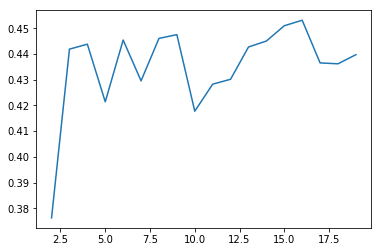

In [183]:
pd.Series(score_list).plot()

In [184]:
labels_9 = KMeans(n_clusters=9,random_state=0).fit_predict(X)

In [185]:
cluster_labels = pd.DataFrame(labels_9,columns=['clusters'])
#cluster_labels
merge_data = pd.concat((data,cluster_labels),axis=1)

In [186]:
merge_data.head(10)

,fbpid,fuid,lifespan,pay_sum,latest_login_time,null,付费,赢牌获得,系统产出,兑换,null.1,高级场,职业场,私人场,中级场,新手场,clusters
0,384C601DAA0369E7BB9AECC1D53D3437,1002348033,264,0.00,2018-07-30,0.0,0.0000,0.0000,100.0000,0.0,0.0,0.00,0.0,0.00,0.00,100.00,6
1,384C601DAA0369E7BB9AECC1D53D3437,1002353776,101,0.00,2018-02-18,0.0,0.0000,0.0000,100.0000,0.0,0.0,0.00,0.0,0.00,17.73,82.27,7
2,384C601DAA0369E7BB9AECC1D53D3437,1002449614,67,0.00,2018-02-20,0.0,0.0000,49.6746,50.3254,0.0,0.0,0.00,0.0,25.59,0.00,74.41,4
3,384C601DAA0369E7BB9AECC1D53D3437,1002774494,24,6.95,2018-04-11,0.0,85.2618,0.0000,14.7382,0.0,0.0,0.94,0.0,0.00,17.89,81.17,4
4,384C601DAA0369E7BB9AECC1D53D3437,1002995874,77,0.00,2018-08-25,0.0,0.0000,59.5219,40.4781,0.0,0.0,0.00,0.0,0.00,1.85,98.15,4
5,384C601DAA0369E7BB9AECC1D53D3437,1003025503,1,0.00,2018-06-30,0.0,0.0000,0.0000,100.0000,0.0,0.0,0.00,0.0,0.00,0.00,100.00,0
6,384C601DAA0369E7BB9AECC1D53D3437,1003035621,33,0.00,2018-08-08,0.0,0.0000,0.0000,100.0000,0.0,0.0,0.00,0.0,0.00,0.00,100.00,0
7,384C601DAA0369E7BB9AECC1D53D3437,1003046855,1,0.00,2018-07-14,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.00,0.0,0.00,0.00,0.00,3
8,BD5FDCFA71A9CD5313766DAE14B56F9F,1002268081,309,0.00,2018-08-25,0.0,0.0000,40.1957,59.8043,0.0,0.0,0.65,0.0,0.00,4.91,94.44,2
9,BD5FDCFA71A9CD5313766DAE14B56F9F,1002455699,251,0.00,2018-08-26,0.0,0.0000,0.9353,99.0647,0.0,0.0,9.40,0.0,0.00,9.46,81.14,6


In [187]:
clustering_count = pd.DataFrame(merge_data['pay_sum'].groupby(merge_data['clusters']).count()).T.rename(
{'clusters':'counts'})
clustering_ratio = (clustering_count/len(merge_data)).round(2).rename({'clusters':'percentage'})

In [188]:
cluster_features = []
for line in range(9):
    label_data = merge_data[merge_data['clusters']== line]
    part1_data = pd.concat((label_data.iloc[:,2:4],label_data.iloc[:,6:16]),axis=1)
    part1_desc = part1_data.describe().round(3)
    merge_data1 = part1_desc.iloc[2,:]
    cluster_features.append(merge_data1)

In [189]:
cluster_pd = pd.DataFrame(cluster_features).T
print('{:*^60}'.format('Detailed features for all clusters:'))
#all_cluster_set = pd.concat((clustering_count,clustering_ratio,cluster_pd),axis=0)
clustering_count
clustering_ratio
cluster_pd

************Detailed features for all clusters:*************


clusters,0,1,2,3,4,5,6,7,8
pay_sum,2046,1367,808,738,1122,352,1051,1419,1097


clusters,0,1,2,3,4,5,6,7,8
pay_sum,0.2,0.14,0.08,0.07,0.11,0.04,0.11,0.14,0.11


,std,std,std,std,std,std,std,std,std
lifespan,13.577,21.726,56.942,20.609,22.864,34.991,22.541,19.327,26.474
pay_sum,0.241,4.529,23.628,1.943,6.734,22.029,19.753,2.679,28.008
付费,2.295,4.411,6.524,7.109,15.793,6.841,8.183,6.732,11.410
赢牌获得,8.385,13.774,25.001,2.706,27.608,18.981,24.089,15.154,19.052
系统产出,8.743,14.601,25.766,47.208,20.811,34.059,25.318,16.603,16.322
兑换,0.000,0.483,0.696,0.000,1.126,0.000,0.499,0.869,0.940
null.1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
高级场,0.989,6.241,17.534,7.751,9.583,0.862,11.022,2.639,14.978
职业场,0.000,1.415,2.066,0.000,0.000,0.000,1.514,0.028,0.965
私人场,6.071,12.268,7.623,1.995,8.721,15.179,10.011,7.653,8.130


In [190]:

num_sets = cluster_pd.T.astype(np.float64)
minmax_data = MinMaxScaler().fit_transform(num_sets)
minmax_data

array([[0.        , 0.        , 0.        , 0.22805397, 0.        ,
        0.        , 0.        , 0.00761756, 0.        , 0.30916262,
        0.22536091, 0.17433921],
       [0.18791652, 0.15442792, 0.15676397, 0.44446229, 0.15229429,
        0.42895204, 0.        , 0.32263676, 0.68489835, 0.77920206,
        0.57465158, 0.82880241],
       [1.        , 0.8422588 , 0.31330567, 0.89530961, 0.44255817,
        0.61811723, 0.        , 1.        , 1.        , 0.42688107,
        0.97012687, 1.        ],
       [0.16215842, 0.06129578, 0.35664543, 0.        , 1.        ,
        0.        , 0.        , 0.41320777, 0.        , 0.        ,
        0.6095244 , 0.        ],
       [0.21415888, 0.23383873, 1.        , 1.        , 0.31373976,
        1.        , 0.        , 0.52309261, 0.        , 0.51016383,
        0.80788701, 0.72483559],
       [0.49380837, 0.78467245, 0.33679064, 0.65356196, 0.65815677,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        ,

(<a list of 26 Line2D ticklines objects>,
 <a list of 13 Text major ticklabel objects>)

(-0.2, 1.2)

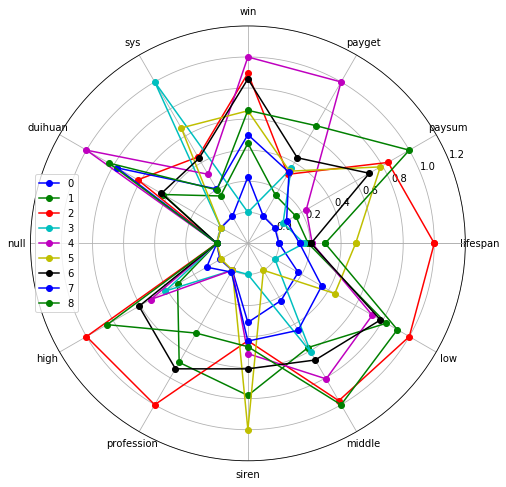

In [191]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111,polar=True)
labels = np.array(['lifespan','paysum','payget','win','sys','duihuan','null','high','profession','siren','middle','low'])
cor_list = ['b','g','r','c','m','y','k','b','g']
angles = np.linspace(0,2*np.pi,len(labels),endpoint=False)
angles = np.concatenate((angles,[angles[0]]))

for i in range(len(num_sets)):
    data_tmp = minmax_data[i,:]
    data = np.concatenate((data_tmp,[data_tmp[0]]))
    ax.plot(angles,data,'o-',c=cor_list[i],label=i)

ax.set_thetagrids(angles*180/np.pi,labels)
ax.set_rlim(-0.2,1.2)
plt.legend(loc=6
          )

(<a list of 26 Line2D ticklines objects>,
 <a list of 13 Text major ticklabel objects>)

(-0.2, 1.2)

(<a list of 26 Line2D ticklines objects>,
 <a list of 13 Text major ticklabel objects>)

(-0.2, 1.2)

(<a list of 26 Line2D ticklines objects>,
 <a list of 13 Text major ticklabel objects>)

(-0.2, 1.2)

(<a list of 26 Line2D ticklines objects>,
 <a list of 13 Text major ticklabel objects>)

(-0.2, 1.2)

(<a list of 26 Line2D ticklines objects>,
 <a list of 13 Text major ticklabel objects>)

(-0.2, 1.2)

(<a list of 26 Line2D ticklines objects>,
 <a list of 13 Text major ticklabel objects>)

(-0.2, 1.2)

(<a list of 26 Line2D ticklines objects>,
 <a list of 13 Text major ticklabel objects>)

(-0.2, 1.2)

(<a list of 26 Line2D ticklines objects>,
 <a list of 13 Text major ticklabel objects>)

(-0.2, 1.2)

(<a list of 26 Line2D ticklines objects>,
 <a list of 13 Text major ticklabel objects>)

(-0.2, 1.2)

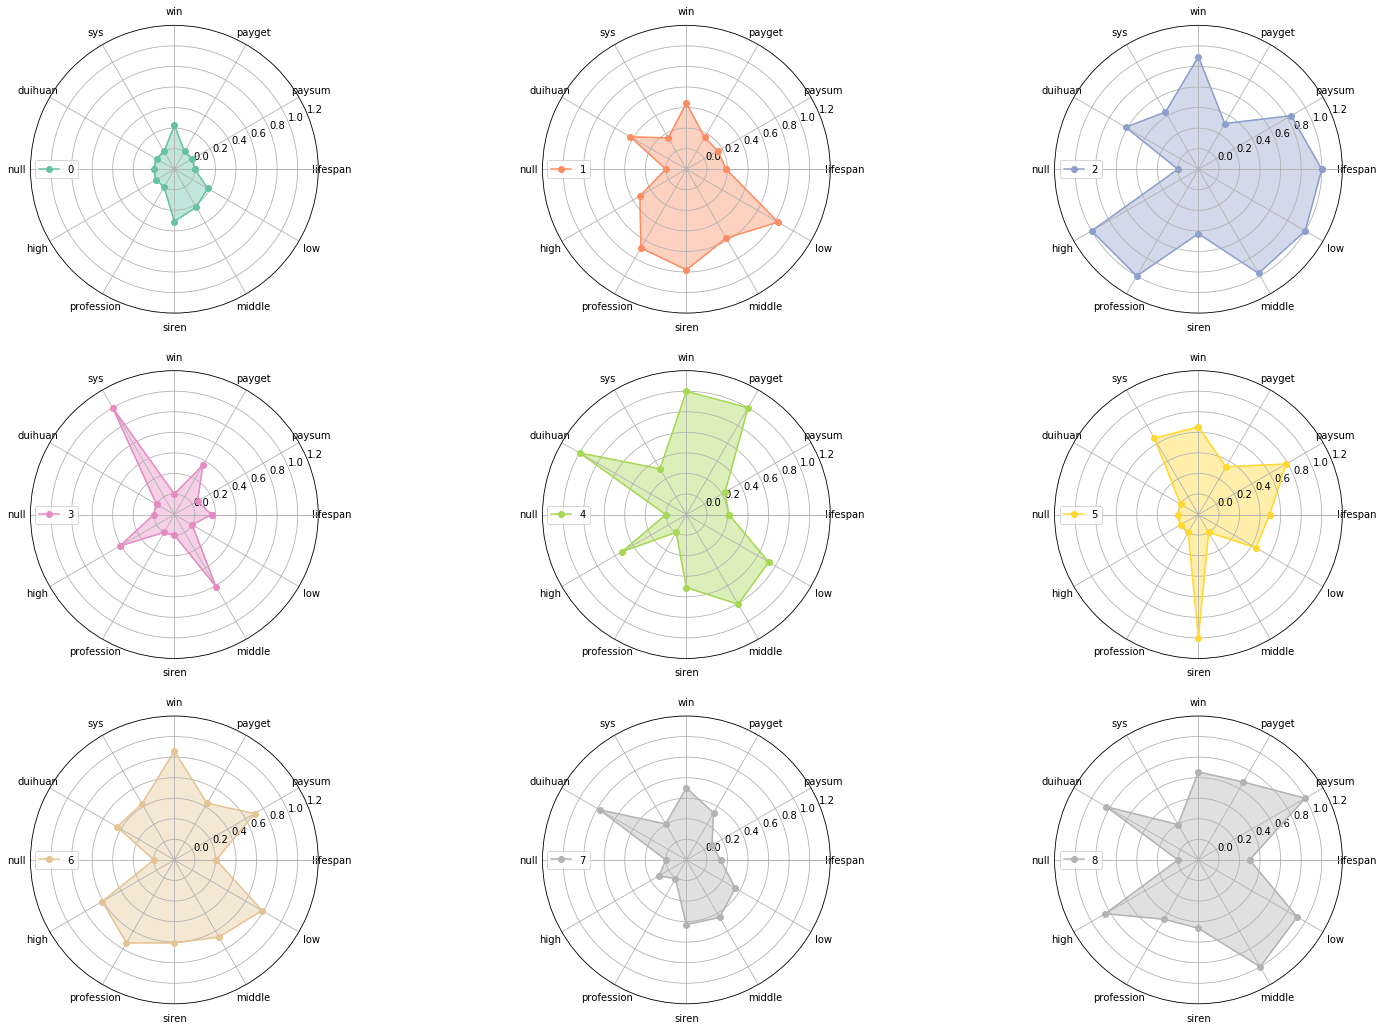

In [192]:
fig = plt.figure(figsize=(26,18))
labels = np.array(['lifespan','paysum','payget','win','sys','duihuan','null','high','profession','siren','middle','low'])
my_palette = plt.cm.get_cmap("Set2", 9)
cor_list = ['b','g','r','c','m','y','k','b','g']
angles = np.linspace(0,2*np.pi,len(labels),endpoint=False)
angles = np.concatenate((angles,[angles[0]]))

for i in range(len(num_sets)):
    ax = fig.add_subplot(3,3,i+1,polar=True)
    data_tmp = minmax_data[i,:]
    data = np.concatenate((data_tmp,[data_tmp[0]]))
    ax.plot(angles,data,'o-',c=my_palette(i),label=i);
    ax.fill(angles, data, color=my_palette(i), alpha=0.4)
    ax.set_thetagrids(angles*180/np.pi,labels)
    ax.set_rlim(-0.2,1.2)
    plt.legend(loc=6)
    


In [3]:
data2 = pd.read_csv('./data_julei_coin.csv')
X2_tmp = data2.iloc[:,5].values
X2_tmp = X2_tmp.reshape(-1,1)
X2_tmp = MinMaxScaler().fit_transform(X2_tmp)

/usr/lib64/python3.4/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [7]:
score_list2 = {}
silhouette_int = -1
for n_clusters in range(2,20):
    model_kmeans = KMeans(n_clusters=n_clusters,random_state=0)
    cluster_labels_tmp = model_kmeans.fit_predict(X2_tmp)
    silhouette_tmp = metrics.silhouette_score(X2_tmp,cluster_labels_tmp)
    if silhouette_tmp > silhouette_int:
        best_k = n_clusters
        silhouette_int = silhouette_tmp
        best_kmeans = model_kmeans
        cluster_labels_k = cluster_labels_tmp
    #score_list.append([n_clusters,silhouette_tmp])
    score_list2[n_clusters] = silhouette_tmp
print('{:*^60}'.format('K value and silhouette summary:'))
print (score_list2)
print ('Best K is :{0} with average silhouette of {1}'.format(best_k,silhouette_int.round(4)))

**************K value and silhouette summary:***************
{2: 0.7897664107427507, 3: 0.7695638136533633, 4: 0.737888387274061, 5: 0.7338465483159292, 6: 0.7040819238156041, 7: 0.6901456050247258, 8: 0.6811488212808833, 9: 0.6633598550456813, 10: 0.650239947470339, 11: 0.6499018042510354, 12: 0.6407654310053753, 13: 0.6404396787004332, 14: 0.6359045573914489, 15: 0.6262752266933147, 16: 0.6275219392888712, 17: 0.6254478682741025, 18: 0.6244864703399853, 19: 0.6125030772439469}
Best K is :2 with average silhouette of 0.7898


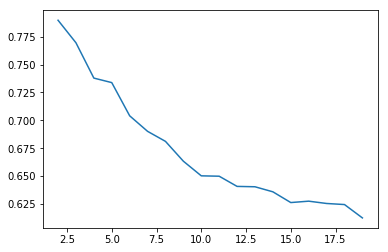

In [33]:
pd.Series(score_list2).plot()

In [6]:
labels_9 = KMeans(n_clusters=10,random_state=0).fit_predict(X2_tmp)
cluster_labels = pd.DataFrame(labels_9,columns=['clusters'])
#cluster_labels
merge_data2 = pd.concat((data2,cluster_labels),axis=1)
merge_data2.groupby('clusters').size()

clusters
0    5282
1     387
2      56
3       1
4    1093
5     205
6       5
7      14
8     671
9    1859
dtype: int64

In [9]:
merge_data2.head(10)

,fbpid,fuid,latest_login_time,lifespan,pay_sum,coin_sum,get_pay,get_win,get_sys,get_duihuan,senior,profession,personal,middle,low,clusters
0,384C601DAA0369E7BB9AECC1D53D3437,1002348033,2018-07-30,264,0.00,11000,0.0000,0.0000,100.0000,0.0,0.00,0.0,0.00,0.00,100.00,0
1,384C601DAA0369E7BB9AECC1D53D3437,1002353776,2018-02-18,101,0.00,42000,0.0000,0.0000,100.0000,0.0,0.00,0.0,0.00,17.73,82.27,0
2,384C601DAA0369E7BB9AECC1D53D3437,1002449614,2018-02-20,67,0.00,132056,0.0000,49.6746,50.3254,0.0,0.00,0.0,25.59,0.00,74.41,0
3,384C601DAA0369E7BB9AECC1D53D3437,1002774494,2018-04-11,24,6.95,191000,85.2618,0.0000,14.7382,0.0,0.94,0.0,0.00,17.89,81.17,0
4,384C601DAA0369E7BB9AECC1D53D3437,1002995874,2018-08-25,77,0.00,130990,0.0000,59.5219,40.4781,0.0,0.00,0.0,0.00,1.85,98.15,0
5,384C601DAA0369E7BB9AECC1D53D3437,1003025503,2018-06-30,1,0.00,2000,0.0000,0.0000,100.0000,0.0,0.00,0.0,0.00,0.00,100.00,0
6,384C601DAA0369E7BB9AECC1D53D3437,1003035621,2018-08-08,33,0.00,6000,0.0000,0.0000,100.0000,0.0,0.00,0.0,0.00,0.00,100.00,0
7,BD5FDCFA71A9CD5313766DAE14B56F9F,1002268081,2018-08-25,309,0.00,899443,0.0000,40.1957,59.8043,0.0,0.65,0.0,0.00,4.91,94.44,4
8,BD5FDCFA71A9CD5313766DAE14B56F9F,1002455699,2018-08-26,251,0.00,463364,0.0000,0.9353,99.0647,0.0,9.40,0.0,0.00,9.46,81.14,9
9,BD5FDCFA71A9CD5313766DAE14B56F9F,1002746429,2018-06-02,85,0.00,130020,0.0000,68.0197,31.9803,0.0,6.30,0.0,0.00,23.59,70.10,0


In [10]:
cluster_features = []
for line in range(10):
    label_data = merge_data2[merge_data2['clusters']== line]
    part1_data = pd.concat((label_data.iloc[:,2:5],label_data.iloc[:,5:16]),axis=1)
    part1_desc = part1_data.describe().round(3)
    merge_data1 = part1_desc.iloc[2,:]
    cluster_features.append(merge_data1)
cluster_pd = pd.DataFrame(cluster_features).T
cluster_pd

,std,std,std,std,std,std,std,std,std,std
lifespan,74.472,69.694,77.735,NaN,75.605,72.367,110.651,68.967,74.867,80.702
pay_sum,1.107,11.186,51.405,NaN,20.305,27.073,238.804,57.347,7.251,2.883
coin_sum,62282.410,271298.190,760596.642,NaN,150967.348,480394.411,2249410.581,1214545.478,184709.455,112659.945
get_pay,6.830,11.387,15.393,NaN,7.712,15.253,38.749,11.226,9.785,9.615
get_win,27.991,23.910,32.301,NaN,21.316,26.693,38.389,25.793,21.675,22.355
get_sys,28.805,23.954,26.957,NaN,21.696,25.958,1.039,5.372,21.972,23.100
get_duihuan,0.481,0.916,0.574,NaN,0.552,1.864,1.448,0.099,0.646,0.897
senior,5.505,15.847,27.169,NaN,10.849,17.001,33.834,32.862,10.668,10.389
profession,1.084,0.793,0.715,NaN,0.306,0.166,0.000,0.157,0.554,1.248
personal,22.391,4.293,1.026,NaN,7.666,3.829,31.792,0.000,3.413,9.614


In [8]:
X_new = pd.concat((merge_data2.iloc[:,3:4],merge_data2.iloc[:,6:15]),axis=1).values
X_new = MinMaxScaler().fit_transform(X_new)

In [60]:
score_list2 = {}
silhouette_int = -1
for n_clusters in range(2,20):
    model_kmeans = KMeans(n_clusters=n_clusters,random_state=0)
    cluster_labels_tmp = model_kmeans.fit_predict(X_new)
    silhouette_tmp = metrics.silhouette_score(X_new,cluster_labels_tmp)
    if silhouette_tmp > silhouette_int:
        best_k = n_clusters
        silhouette_int = silhouette_tmp
        best_kmeans = model_kmeans
        cluster_labels_k = cluster_labels_tmp
    #score_list.append([n_clusters,silhouette_tmp])
    score_list2[n_clusters] = silhouette_tmp
print('{:*^60}'.format('K value and silhouette summary:'))
print (score_list2)
print ('Best K is :{0} with average silhouette of {1}'.format(best_k,silhouette_int.round(4)))

**************K value and silhouette summary:***************
{2: 0.39593084275782997, 3: 0.46994900904918707, 4: 0.41634177840874853, 5: 0.4413765984078043, 6: 0.42925742134383926, 7: 0.43854218019523444, 8: 0.4385999435483591, 9: 0.40815413602295747, 10: 0.4199438676111815, 11: 0.42437787090113277, 12: 0.4299728806228892, 13: 0.4291180848419318, 14: 0.4340908582410301, 15: 0.41273174865426215, 16: 0.41673072273560946, 17: 0.4199757591461643, 18: 0.4228095103035804, 19: 0.4221854028710818}
Best K is :3 with average silhouette of 0.4699


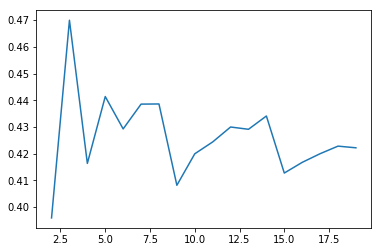

In [61]:
pd.Series(score_list2).plot()

In [9]:
labels_9 = KMeans(n_clusters=5,random_state=0).fit_predict(X_new)
cluster_labels = pd.DataFrame(labels_9,columns=['clusters2'])
#cluster_labels
merge_data3 = pd.concat((merge_data2,cluster_labels),axis=1)
merge_data3.groupby('clusters2').size()

clusters2
0    1565
1    3884
2     643
3    3091
4     390
dtype: int64

In [125]:
merge_data3[merge_data3['clusters2']==6].describe().T

,count,mean,std,min,25%,50%,75%,max
fuid,146.0,1.002740e+09,2.258621e+05,1.002253e+09,1.002557e+09,1.002747e+09,1.002929e+09,1.003122e+09
lifespan,146.0,9.666438e+01,7.645069e+01,1.000000e+00,3.525000e+01,7.500000e+01,1.470000e+02,3.100000e+02
pay_sum,146.0,4.726377e+01,1.028741e+02,0.000000e+00,4.962500e+00,1.492000e+01,4.291250e+01,6.618500e+02
coin_sum,146.0,1.387689e+06,2.764596e+06,2.731000e+03,1.310260e+05,4.120000e+05,1.372462e+06,1.647807e+07
get_pay,146.0,6.209435e+01,2.228186e+01,0.000000e+00,4.576940e+01,5.898520e+01,8.106100e+01,1.000000e+02
get_win,146.0,1.140748e+01,1.215617e+01,0.000000e+00,0.000000e+00,7.126550e+00,1.970590e+01,4.690130e+01
get_sys,146.0,2.182206e+01,1.615611e+01,0.000000e+00,9.401400e+00,1.867740e+01,3.397400e+01,6.287890e+01
get_duihuan,146.0,8.506199e-01,4.373223e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.138800e+01
senior,146.0,6.625753e+00,1.831607e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.817500e+00,9.973000e+01
profession,146.0,6.219178e-02,5.380085e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.350000e+00


In [21]:
cluster_features = []
for line in range(5):
    label_data = merge_data3[merge_data3['clusters2']== line]
    part1_data = pd.concat((label_data.iloc[:,2:5],label_data.iloc[:,5:15]),axis=1)
    part1_desc = part1_data.describe().round(3)
    merge_data1 = pd.concat((part1_desc.iloc[2,0:4],part1_desc.iloc[5,4:12]),axis=0)
    cluster_features.append(merge_data1)
cluster_pd = pd.DataFrame(cluster_features).T
cluster_pd

,0,1,2,3,4
lifespan,107.285,81.123,88.599,86.690,65.786
pay_sum,31.532,0.943,0.201,9.020,20.939
coin_sum,1984611.879,514190.511,191251.654,730105.063,853246.151
get_pay,10.600,2.226,2.415,12.244,6.956
get_win,72.586,0.000,0.000,39.715,0.000
get_sys,25.748,100.000,100.000,57.896,100.000
get_duihuan,0.000,0.000,0.000,0.000,0.000
senior,2.260,0.000,0.000,0.000,0.000
profession,0.000,0.000,0.000,0.000,0.000
personal,0.000,0.000,0.000,0.000,89.510


In [22]:
num_sets = cluster_pd.T.astype(np.float64)
minmax_data = MinMaxScaler().fit_transform(num_sets)

(<a list of 26 Line2D ticklines objects>,
 <a list of 13 Text major ticklabel objects>)

(-0.2, 1.2)

(<a list of 26 Line2D ticklines objects>,
 <a list of 13 Text major ticklabel objects>)

(-0.2, 1.2)

(<a list of 26 Line2D ticklines objects>,
 <a list of 13 Text major ticklabel objects>)

(-0.2, 1.2)

(<a list of 26 Line2D ticklines objects>,
 <a list of 13 Text major ticklabel objects>)

(-0.2, 1.2)

(<a list of 26 Line2D ticklines objects>,
 <a list of 13 Text major ticklabel objects>)

(-0.2, 1.2)

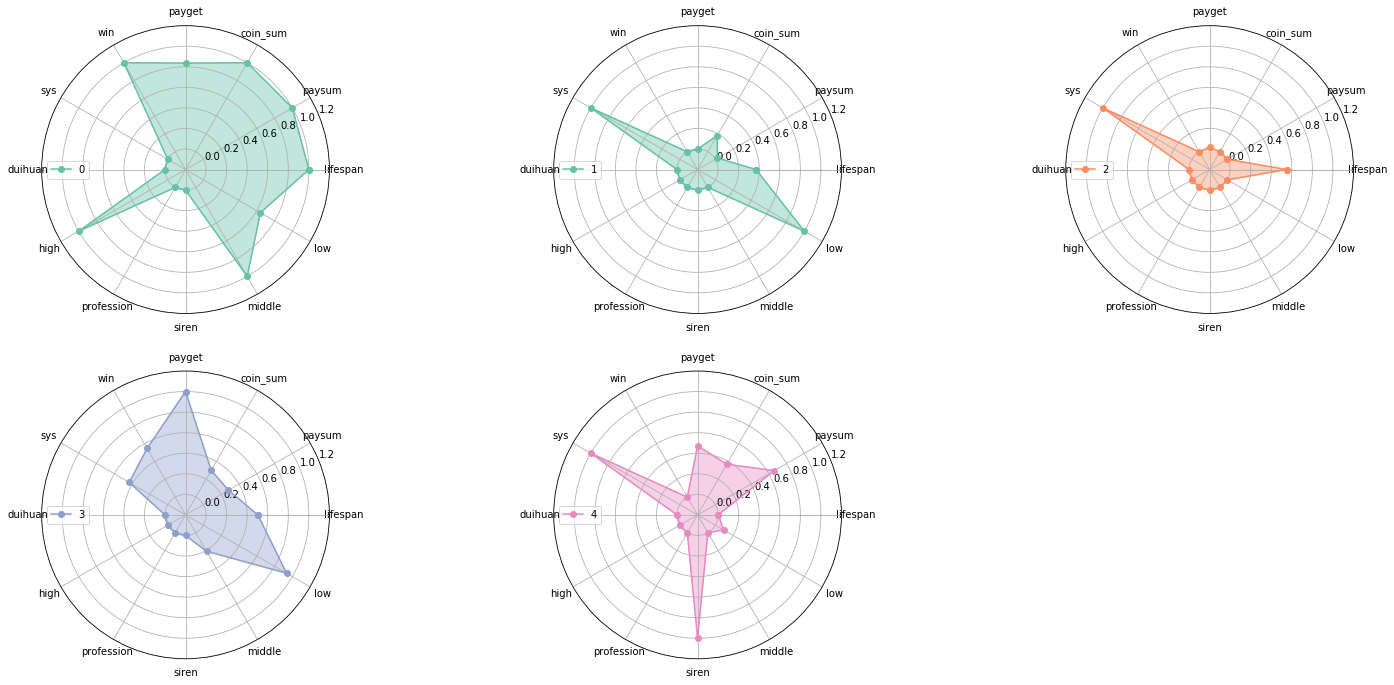

In [23]:
fig = plt.figure(figsize=(26,18))
labels = np.array(['lifespan','paysum','coin_sum','payget','win','sys','duihuan','high','profession','siren','middle','low'])
my_palette = plt.cm.get_cmap("Set2", 10)
cor_list = ['b','g','r','c','m','y','k','b','g']
angles = np.linspace(0,2*np.pi,len(labels),endpoint=False)
angles = np.concatenate((angles,[angles[0]]))

for i in range(len(num_sets)):
    ax = fig.add_subplot(3,3,i+1,polar=True)
    data_tmp = minmax_data[i,:]
    data = np.concatenate((data_tmp,[data_tmp[0]]))
    ax.plot(angles,data,'o-',c=my_palette(i),label=i);
    ax.fill(angles, data, color=my_palette(i), alpha=0.4)
    ax.set_thetagrids(angles*180/np.pi,labels)
    ax.set_rlim(-0.2,1.2)
    plt.legend(loc=6)
    


In [11]:
from sklearn.cluster import AgglomerativeClustering

In [26]:
score_list3 = {}
silhouette_int = -1
for n_clusters in range(2,20):
    model_kmeans = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels_tmp = model_kmeans.fit_predict(X_new)
    silhouette_tmp = metrics.silhouette_score(X_new,cluster_labels_tmp)
    if silhouette_tmp > silhouette_int:
        best_k = n_clusters
        silhouette_int = silhouette_tmp
        best_kmeans = model_kmeans
        cluster_labels_k = cluster_labels_tmp
    #score_list.append([n_clusters,silhouette_tmp])
    score_list3[n_clusters] = silhouette_tmp
print('{:*^60}'.format('K value and silhouette summary:'))
print (score_list3)
print ('Best K is :{0} with average silhouette of {1}'.format(best_k,silhouette_int.round(4)))

**************K value and silhouette summary:***************
{2: 0.3798087007408381, 3: 0.44331319712639145, 4: 0.4076040077253053, 5: 0.4312098540756094, 6: 0.36792916033787876, 7: 0.365331093974685, 8: 0.38027522667229213, 9: 0.37049516512636704, 10: 0.37662523804313924, 11: 0.38533082223865156, 12: 0.3605320819745541, 13: 0.364358416558917, 14: 0.3655205671267991, 15: 0.36800551220265654, 16: 0.3703466692704129, 17: 0.36852388083526844, 18: 0.36967294387656735, 19: 0.3616961900757544}
Best K is :3 with average silhouette of 0.4433


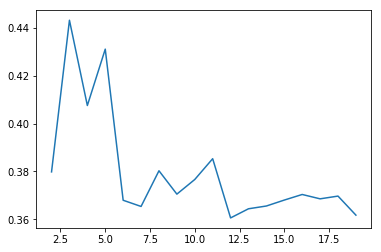

In [27]:
pd.Series(score_list3).plot()

In [12]:
labels_9 = AgglomerativeClustering(n_clusters=5).fit_predict(X_new)
cluster_labels = pd.DataFrame(labels_9,columns=['clusters3'])
#cluster_labels
merge_data3 = pd.concat((merge_data2,cluster_labels),axis=1)
merge_data3.groupby('clusters3').size()

clusters3
0    5048
1    2613
2     305
3    1074
4     533
dtype: int64

In [13]:
cluster_features = []
for line in range(5):
    label_data = merge_data3[merge_data3['clusters3']== line]
    part1_data = pd.concat((label_data.iloc[:,2:5],label_data.iloc[:,5:15]),axis=1)
    part1_desc = part1_data.describe().round(3)
    merge_data1 = pd.concat((part1_desc.iloc[2,0:4],part1_desc.iloc[5,4:12]),axis=0)
    #merge_data1 = part1_desc.iloc[2,:]
    cluster_features.append(merge_data1)
cluster_pd = pd.DataFrame(cluster_features).T
cluster_pd

,0,1,2,3,4
lifespan,86.635,95.499,65.630,92.834,56.854
pay_sum,1.121,26.768,0.652,9.561,0.000
coin_sum,555324.262,1040779.921,191215.293,2062699.692,82894.986
get_pay,2.573,15.462,1.183,2.816,0.000
get_win,4.978,49.683,0.000,64.915,0.000
get_sys,94.363,46.445,100.000,34.222,100.000
get_duihuan,0.000,0.000,0.000,0.000,0.000
senior,0.000,0.000,0.000,8.390,0.000
profession,0.000,0.000,0.000,0.000,0.000
personal,0.000,0.000,96.280,0.000,0.000


In [14]:
merge_data3[merge_data3['clusters3']==3]

,fbpid,fuid,latest_login_time,lifespan,pay_sum,coin_sum,get_pay,get_win,get_sys,get_duihuan,senior,profession,personal,middle,low,clusters,clusters3
20,BD5FDCFA71A9CD5313766DAE14B56F9F,1002365397,2018-07-23,252,0.00,13236,0.0000,25.4678,74.5322,0.0000,92.49,0.00,0.00,0.00,7.51,0,3
30,384C601DAA0369E7BB9AECC1D53D3437,1002371573,2018-06-28,225,0.00,626619,0.0000,44.3975,37.5368,0.0000,16.49,0.00,0.00,79.59,3.91,4,3
40,BD5FDCFA71A9CD5313766DAE14B56F9F,1002592520,2018-08-26,211,0.00,968582,0.0000,34.6634,64.8966,0.0000,6.10,0.00,0.00,36.81,57.09,4,3
45,384C601DAA0369E7BB9AECC1D53D3437,1002519329,2018-08-26,234,0.00,5785466,0.0000,84.3955,15.6045,0.0000,6.61,0.00,0.00,45.39,48.00,2,3
49,384C601DAA0369E7BB9AECC1D53D3437,1002982792,2018-08-26,86,0.00,692616,0.0000,52.9396,47.0604,0.0000,9.39,0.00,0.00,26.84,63.77,4,3
51,BD5FDCFA71A9CD5313766DAE14B56F9F,1002250941,2018-03-01,133,0.00,270281,0.0000,79.8282,20.1718,0.0000,3.32,0.61,0.00,24.10,71.97,9,3
52,BD5FDCFA71A9CD5313766DAE14B56F9F,1002265270,2018-08-25,309,0.00,8692675,0.0000,97.3364,2.6636,0.0000,0.65,0.00,0.00,97.41,1.95,7,3
53,BD5FDCFA71A9CD5313766DAE14B56F9F,1002279864,2018-04-02,163,0.00,1937658,0.0000,87.4053,12.5947,0.0000,12.86,6.07,0.00,47.17,33.89,1,3
57,BD5FDCFA71A9CD5313766DAE14B56F9F,1002731559,2018-08-15,162,0.00,1009948,0.0000,70.5608,28.8728,0.0000,32.67,0.00,1.69,11.52,54.12,4,3
68,BD5FDCFA71A9CD5313766DAE14B56F9F,1002431205,2018-08-26,259,0.00,503240,0.0000,4.2291,95.7709,0.0000,100.00,0.00,0.00,0.00,0.00,9,3


In [16]:
num_sets = cluster_pd.T.astype(np.float64)
minmax_data = MinMaxScaler().fit_transform(num_sets)

(<a list of 26 Line2D ticklines objects>,
 <a list of 13 Text major ticklabel objects>)

(-0.2, 1.2)

(<a list of 26 Line2D ticklines objects>,
 <a list of 13 Text major ticklabel objects>)

(-0.2, 1.2)

(<a list of 26 Line2D ticklines objects>,
 <a list of 13 Text major ticklabel objects>)

(-0.2, 1.2)

(<a list of 26 Line2D ticklines objects>,
 <a list of 13 Text major ticklabel objects>)

(-0.2, 1.2)

(<a list of 26 Line2D ticklines objects>,
 <a list of 13 Text major ticklabel objects>)

(-0.2, 1.2)

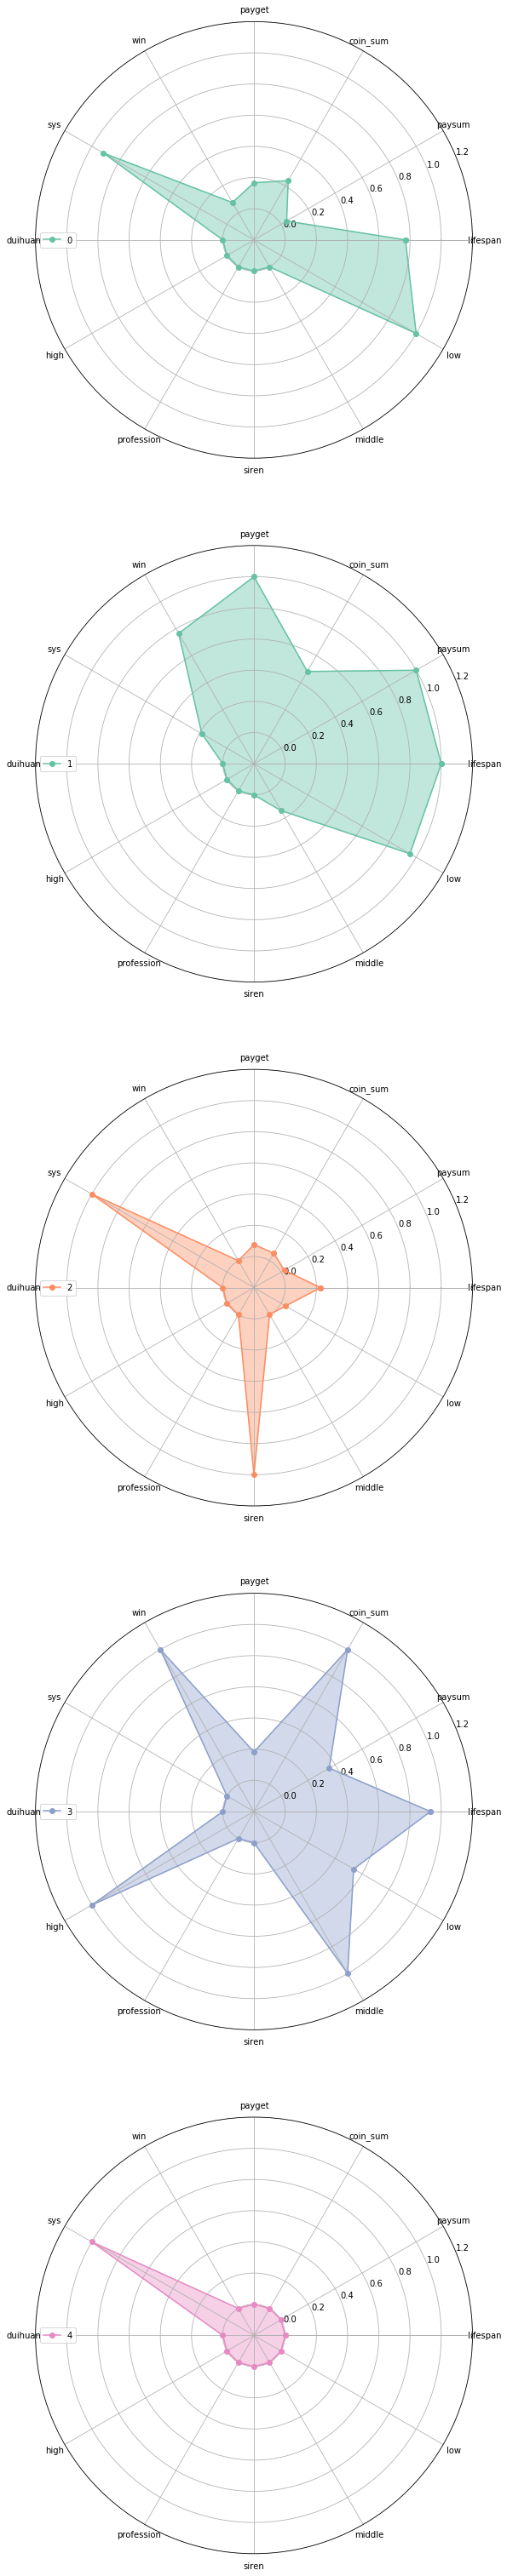

In [21]:
fig = plt.figure(figsize=(26,100))
labels = np.array(['lifespan','paysum','coin_sum','payget','win','sys','duihuan','high','profession','siren','middle','low'])
my_palette = plt.cm.get_cmap("Set2", 10)
cor_list = ['b','g','r','c','m','y','k','b','g']
angles = np.linspace(0,2*np.pi,len(labels),endpoint=False)
angles = np.concatenate((angles,[angles[0]]))

for i in range(len(num_sets)):
    ax = fig.add_subplot(9,1,i+1,polar=True)
    data_tmp = minmax_data[i,:]
    data = np.concatenate((data_tmp,[data_tmp[0]]))
    ax.plot(angles,data,'o-',c=my_palette(i),label=i);
    ax.fill(angles, data, color=my_palette(i), alpha=0.4)
    ax.set_thetagrids(angles*180/np.pi,labels)
    ax.set_rlim(-0.2,1.2)
    plt.legend(loc=6)
    

In [41]:
merge_data3.head(10)

,fbpid,fuid,latest_login_time,lifespan,pay_sum,coin_sum,get_pay,get_win,get_sys,get_duihuan,senior,profession,personal,middle,low,clusters,clusters3
0,384C601DAA0369E7BB9AECC1D53D3437,1002348033,2018-07-30,264,0.00,11000,0.0000,0.0000,100.0000,0.0,0.00,0.0,0.00,0.00,100.00,0,0
1,384C601DAA0369E7BB9AECC1D53D3437,1002353776,2018-02-18,101,0.00,42000,0.0000,0.0000,100.0000,0.0,0.00,0.0,0.00,17.73,82.27,0,0
2,384C601DAA0369E7BB9AECC1D53D3437,1002449614,2018-02-20,67,0.00,132056,0.0000,49.6746,50.3254,0.0,0.00,0.0,25.59,0.00,74.41,0,0
3,384C601DAA0369E7BB9AECC1D53D3437,1002774494,2018-04-11,24,6.95,191000,85.2618,0.0000,14.7382,0.0,0.94,0.0,0.00,17.89,81.17,0,1
4,384C601DAA0369E7BB9AECC1D53D3437,1002995874,2018-08-25,77,0.00,130990,0.0000,59.5219,40.4781,0.0,0.00,0.0,0.00,1.85,98.15,0,1
5,384C601DAA0369E7BB9AECC1D53D3437,1003025503,2018-06-30,1,0.00,2000,0.0000,0.0000,100.0000,0.0,0.00,0.0,0.00,0.00,100.00,0,0
6,384C601DAA0369E7BB9AECC1D53D3437,1003035621,2018-08-08,33,0.00,6000,0.0000,0.0000,100.0000,0.0,0.00,0.0,0.00,0.00,100.00,0,0
7,BD5FDCFA71A9CD5313766DAE14B56F9F,1002268081,2018-08-25,309,0.00,899443,0.0000,40.1957,59.8043,0.0,0.65,0.0,0.00,4.91,94.44,4,1
8,BD5FDCFA71A9CD5313766DAE14B56F9F,1002455699,2018-08-26,251,0.00,463364,0.0000,0.9353,99.0647,0.0,9.40,0.0,0.00,9.46,81.14,9,0
9,BD5FDCFA71A9CD5313766DAE14B56F9F,1002746429,2018-06-02,85,0.00,130020,0.0000,68.0197,31.9803,0.0,6.30,0.0,0.00,23.59,70.10,0,1


<Figure size 720x576 with 0 Axes>

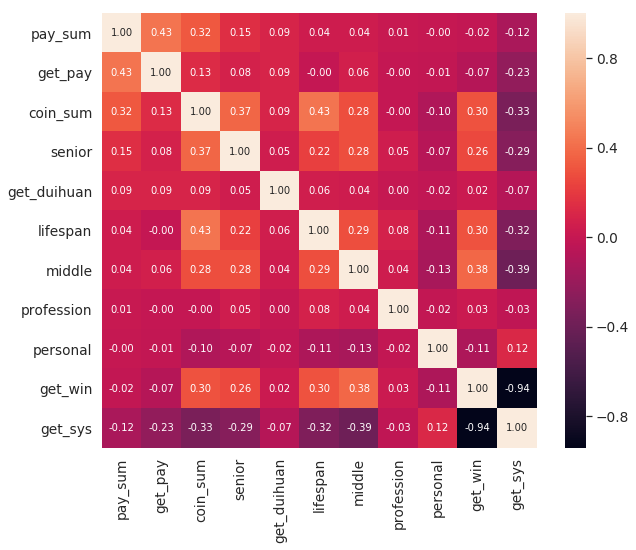

In [42]:
import seaborn as sns
corrmat = merge_data3.iloc[:,3:14].corr(method='pearson')
cols = corrmat.nlargest(15, 'pay_sum')['pay_sum'].index
cm = np.corrcoef(merge_data3[cols].values.T)
plt.figure(figsize=(10,8))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [18]:
merge_data3.to_csv('./cluster_result2.csv')